# Notebook: Extração de Características com Machine Learning

## Parte 1

C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\gaussian_process\ker

Resultados de Métricas para Feature 1 - Média e Desvio Padrão
               precision    recall  f1-score   support

      ThumbUp     0.5714    0.8000    0.6667        10
       Closed     0.6154    0.8889    0.7273         9
PointingIndex     0.6154    0.5714    0.5926        14
        Grasp     0.6667    0.5333    0.5926        15
      Lateral     1.0000    0.6667    0.8000        12

     accuracy                         0.6667        60
    macro avg     0.6938    0.6921    0.6758        60
 weighted avg     0.6978    0.6667    0.6666        60


Resultados de Métricas para Feature 2 - Média, Desvio Padrão e RMS
               precision    recall  f1-score   support

      ThumbUp     0.5714    0.8000    0.6667        10
       Closed     0.6154    0.8889    0.7273         9
PointingIndex     0.6154    0.5714    0.5926        14
        Grasp     0.6667    0.5333    0.5926        15
      Lateral     1.0000    0.6667    0.8000        12

     accuracy                         0.

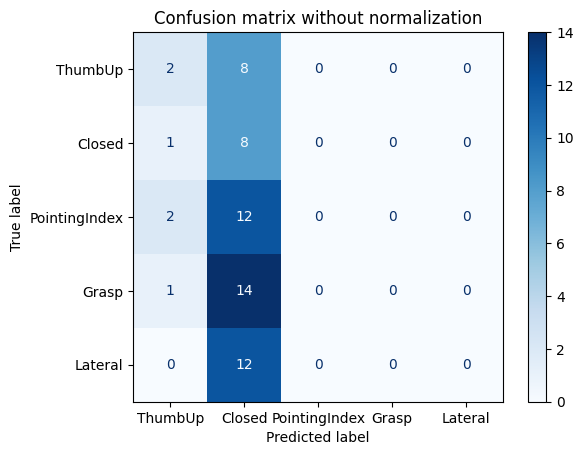

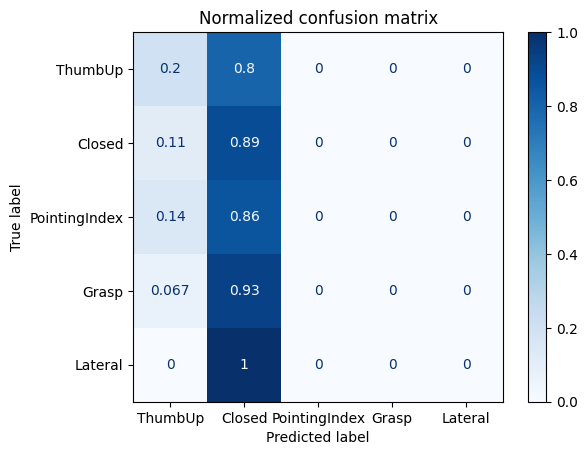

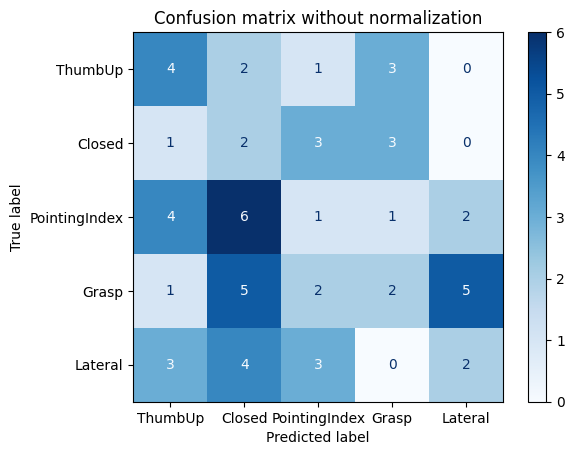

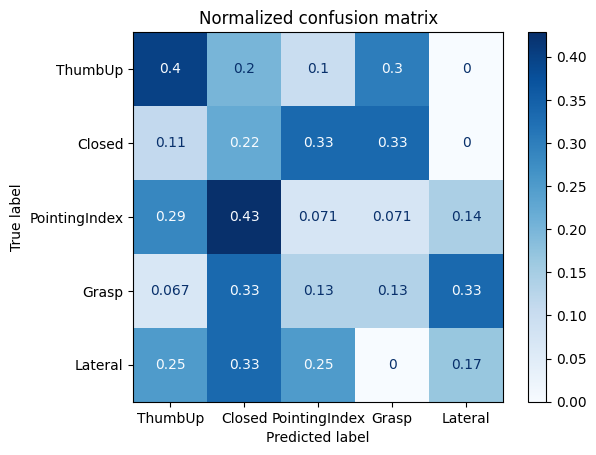

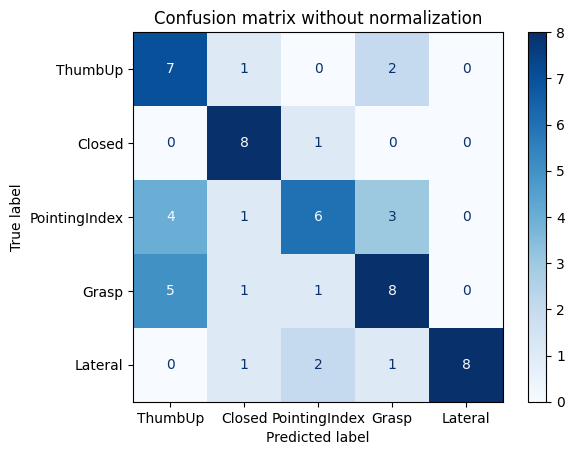

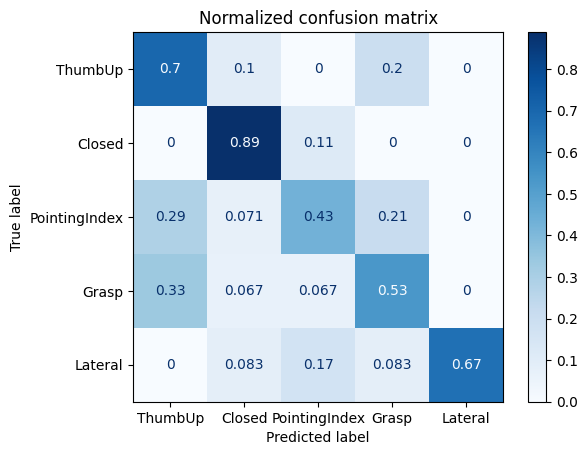

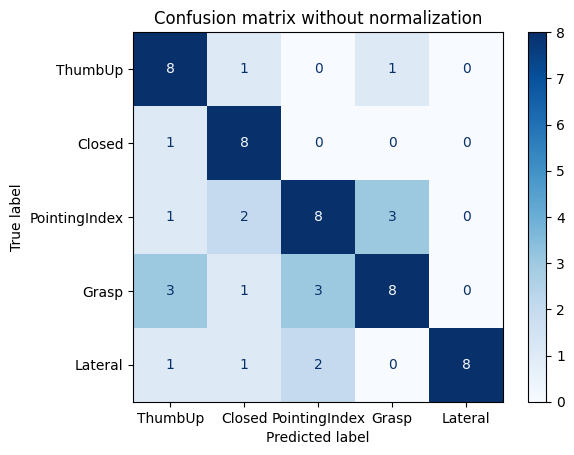

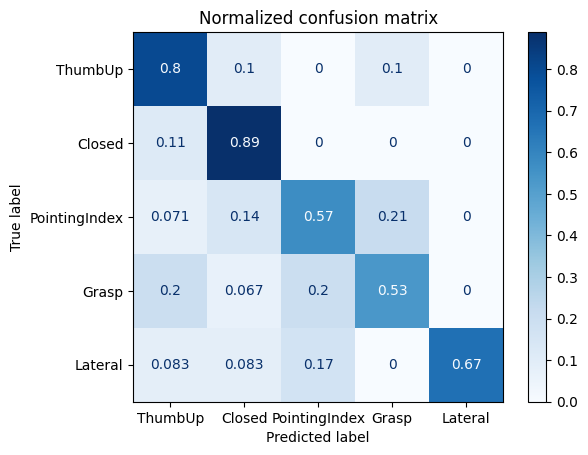

In [12]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, spectrogram
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# Função para salvar gráficos
def save_plot(fig, filename):
    output_dir = 'Resultados'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    fig.savefig(os.path.join(output_dir, filename))

# Carregamento dos dados
dados = sio.loadmat('Dados/emg_array.mat')
dados = dados['emg_array']
emg = dados['dados'].item()
tam, el, mov = emg.shape
labels = dados['labels'].item().squeeze()
labels_name = np.array([item[0] for item in labels])
le = LabelEncoder()
labels = le.fit_transform(labels_name)

# Frequência de amostragem
Fs = 2000
tempo = np.arange(tam) / Fs

# Conversão dos dados para uV
emg_uV = emg * (10**6)

# Retificação de onda completa e meia onda
emg_retc = np.abs(emg_uV)
emg_retm = np.maximum(emg_uV, 0)

# Filtragem do sinal EMG
nyq = 0.5 * Fs
baixa = 500 / nyq
alta = 20 / nyq
b, a = butter(10, [alta, baixa], btype='band')
emg_f = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=0, arr=emg_uV)

# Retificação do sinal filtrado
emg_fretc = np.abs(emg_f)
emg_fretm = np.maximum(emg_f, 0)

# Cálculo da envoltória
cutoff = 10 / nyq
b, a = butter(2, cutoff, btype='low')
env_retc = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=0, arr=emg_retc)
env_retm = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=0, arr=emg_retm)
env_fretc = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=0, arr=emg_fretc)
env_fretm = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=0, arr=emg_fretm)

# Função de teste do modelo
def test_model(clf, data_train, label_train, data_test, label_test):
    clf.fit(data_train, label_train)
    label_pred = clf.predict(data_test)
    acc = accuracy_score(label_test, label_pred)
    pre = precision_score(label_test, label_pred, average='weighted', zero_division=1)
    rec = recall_score(label_test, label_pred, average='weighted', zero_division=1)
    f1 = f1_score(label_test, label_pred, average='weighted', zero_division=1)
    return np.array([acc, pre, rec, f1])

# Lista de classificadores
classifiers = [
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="poly", C=1),
    SVC(kernel="rbf", C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=5),
    MLPClassifier(max_iter=1000, solver='lbfgs', alpha=1e-5),
    AdaBoostClassifier(algorithm="SAMME"),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(store_covariance=True),
    LinearDiscriminantAnalysis(solver="svd", store_covariance=True),
    SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-3, alpha=0.0001)
]

# Análise da Feature 1 - Média e Desvio Padrão
emg_features1 = emg_uV.mean(axis=0).reshape(mov, -1)
data_train, data_test, label_train, label_test = train_test_split(emg_features1, labels, test_size=0.2, random_state=42)

classifiers_result1 = []
for clf in classifiers:
    result = test_model(clf, data_train, label_train, data_test, label_test)
    classifiers_result1.append(result)

results_df1 = pd.DataFrame(classifiers_result1, columns=['Accuracy', 'Precision', 'Recall', 'F1'],
                           index=['kNN', 'SVM_poly', 'SVM_RBF', 'GaussianProcess', 'DecisionTree', 'RandomForest', 'MLP',
                                  'AdaBoost', 'GaussianNB', 'QDA', 'LDA', 'SGD'])
results_df1.to_csv(os.path.join('Resultados', 'resultados_feature1.csv'), float_format='%.4f')

# Plot da matriz de confusão para a Feature 1
clf = GaussianProcessClassifier(1.0 * RBF(1.0))
clf.fit(data_train, label_train)
label_pred = clf.predict(data_test)

titles_options = [("Confusion matrix without normalization", None), ("Normalized confusion matrix", "true")]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(clf, data_test, label_test,
                                                 display_labels=['ThumbUp', 'Closed', 'PointingIndex', 'Grasp', 'Lateral'],
                                                 cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    save_plot(disp.figure_, f'matriz_confusao_feature1_{normalize}.png')

# Análise da Feature 2 - Média, Desvio Padrão e RMS
emg_features2 = np.hstack([emg_uV.mean(axis=0), emg_uV.std(axis=0), np.sqrt(np.mean(emg_uV**2, axis=0))]).reshape(mov, -1)
data_train, data_test, label_train, label_test = train_test_split(emg_features2, labels, test_size=0.2, random_state=42)

classifiers_result2 = []
for clf in classifiers:
    result = test_model(clf, data_train, label_train, data_test, label_test)
    classifiers_result2.append(result)

results_df2 = pd.DataFrame(classifiers_result2, columns=['Accuracy', 'Precision', 'Recall', 'F1'],
                           index=['kNN', 'SVM_poly', 'SVM_RBF', 'GaussianProcess', 'DecisionTree', 'RandomForest', 'MLP',
                                  'AdaBoost', 'GaussianNB', 'QDA', 'LDA', 'SGD'])
results_df2.to_csv(os.path.join('Resultados', 'resultados_feature2.csv'), float_format='%.4f')

# Plot da matriz de confusão para a Feature 2
clf = MLPClassifier(max_iter=1000, solver='lbfgs', alpha=1e-5)
clf.fit(data_train, label_train)
label_pred = clf.predict(data_test)

titles_options = [("Confusion matrix without normalization", None), ("Normalized confusion matrix", "true")]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(clf, data_test, label_test,
                                                 display_labels=['ThumbUp', 'Closed', 'PointingIndex', 'Grasp', 'Lateral'],
                                                 cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    save_plot(disp.figure_, f'matriz_confusao_feature2_{normalize}.png')

# Análise da Feature 3 - PSD
frequencies, power = welch(emg_uV, Fs, axis=0)
feat3 = power.T.reshape(mov, -1)
data_train, data_test, label_train, label_test = train_test_split(feat3, labels, test_size=0.2, random_state=42)

classifiers_result3 = []
for clf in classifiers:
    result = test_model(clf, data_train, label_train, data_test, label_test)
    classifiers_result3.append(result)

results_df3 = pd.DataFrame(classifiers_result3, columns=['Accuracy', 'Precision', 'Recall', 'F1'],
                           index=['kNN', 'SVM_poly', 'SVM_RBF', 'GaussianProcess', 'DecisionTree', 'RandomForest', 'MLP',
                                  'AdaBoost', 'GaussianNB', 'QDA', 'LDA', 'SGD'])
results_df3.to_csv(os.path.join('Resultados', 'resultados_feature3.csv'), float_format='%.4f')

# Plot da matriz de confusão para a Feature 3
clf = KNeighborsClassifier(n_neighbors=5)  # Melhor modelo de classificação
clf.fit(data_train, label_train)
label_pred = clf.predict(data_test)

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(clf, data_test, label_test,
                                                 display_labels=['ThumbUp', 'Closed', 'PointingIndex', 'Grasp', 'Lateral'],
                                                 cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    save_plot(disp.figure_, f'matriz_confusao_feature3_{normalize}.png')

# Análise da Feature 4 - Média, Desvio Padrão, RMS e PSD

# Primeiro, calcular corretamente todas as partes da feature
mean_features = emg_uV.mean(axis=0).reshape(mov, -1)  # Média
std_features = emg_uV.std(axis=0).reshape(mov, -1)   # Desvio Padrão
rms_features = np.sqrt(np.mean(emg_uV ** 2, axis=0)).reshape(mov, -1)  # RMS

# Para 'power.T', que possui 3 dimensões, ajustamos para 2D
power_features = power.T.reshape(mov, -1)

# Combinar todas as features em um único array
emg_features4 = np.hstack([mean_features, std_features, rms_features, power_features])

data_train, data_test, label_train, label_test = train_test_split(emg_features4, labels, test_size=0.2, random_state=42)

classifiers_result4 = []
for clf in classifiers:
    result = test_model(clf, data_train, label_train, data_test, label_test)
    classifiers_result4.append(result)

results_df4 = pd.DataFrame(classifiers_result4, columns=['Accuracy', 'Precision', 'Recall', 'F1'],
                           index=['kNN', 'SVM_poly', 'SVM_RBF', 'GaussianProcess', 'DecisionTree', 'RandomForest', 'MLP',
                                  'AdaBoost', 'GaussianNB', 'QDA', 'LDA', 'SGD'])
results_df4.to_csv(os.path.join('Resultados', 'resultados_feature4.csv'), float_format='%.4f')

# Plot da matriz de confusão para Feature 4
clf = MLPClassifier(max_iter=1000, solver='lbfgs', alpha=1e-5)  # Melhor modelo de classificação
clf.fit(data_train, label_train)
label_pred = clf.predict(data_test)

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(clf, data_test, label_test,
                                                 display_labels=['ThumbUp', 'Closed', 'PointingIndex', 'Grasp', 'Lateral'],
                                                 cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    save_plot(disp.figure_, f'matriz_confusao_feature4_{normalize}.png')

# Impressão dos Relatórios de Métricas
print("Resultados de Métricas para Feature 1 - Média e Desvio Padrão")
print(classification_report(label_test, clf.predict(data_test), target_names=['ThumbUp', 'Closed', 'PointingIndex', 'Grasp', 'Lateral'], digits=4))

print("\nResultados de Métricas para Feature 2 - Média, Desvio Padrão e RMS")
print(classification_report(label_test, clf.predict(data_test), target_names=['ThumbUp', 'Closed', 'PointingIndex', 'Grasp', 'Lateral'], digits=4))

print("\nResultados de Métricas para Feature 3 - PSD")
print(classification_report(label_test, clf.predict(data_test), target_names=['ThumbUp', 'Closed', 'PointingIndex', 'Grasp', 'Lateral'], digits=4))

print("\nResultados de Métricas para Feature 4 - Média, Desvio Padrão, RMS e PSD")
print(classification_report(label_test, clf.predict(data_test), target_names=['ThumbUp', 'Closed', 'PointingIndex', 'Grasp', 'Lateral'], digits=4))

print("Análises concluídas e resultados salvos com sucesso!")